# Figure 5

In this tutorial, we explain the experimental setup of Figure 5 for Phoneme dataset. Here, we also provide  feature map  $ \phi_{p,2}(\mathbf{x}_i~|~\mathbf{a}^{(1)}_i,\mathbf{a}_i^{(2)})$ that increases the dimension of the input data by two and elaborate the anchor point selection.

In [1]:
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
from time import time
import DataReader as DR

The following function, takes training data 'X' and its labels  'y' as parameters. Then, it returns the points from the $first$ $class$  whose minimum distances from the each point belonging the second class are greater than  the predifined lower bound.

In [2]:
def find_anchors_from_class_0(X,y):
    y_u=np.unique(y)
    points_of_class1=X[y==y_u[1]]
    distances= []
    #find all distances
    for a in points_of_class1:
        distances.append(linalg.norm(X[y== y_u[0]] -a, axis=1, ord=1))
    #get minimum distances
    distances = np.array(distances)
    min_distance= np.min(distances,axis=0)
    min_distance = min_distance / np.std(min_distance)
   
    inds=[]
    # get the indicies of the points whose minimum distance is greater than the lower bound
    inds.append(min_distance >= np.min(min_distance)+np.std(min_distance)*0.43)
    inds.append(min_distance <= np.max(min_distance))
    all_inds= np.all(inds,axis=0)
    tempX=X[y==y_u[0]]
    return  tempX[all_inds]

As in the previous case, the following function takes training data 'X' and its labels 'y' as parameters. Then, it finds the points belonging the $second$ $class$ whose minimum distances from the first class of points are greater than the lower bound.

In [3]:
def find_anchors_from_class_1(X,y):
    y_u=np.unique(y)
    points_of_class0=X[y==y_u[0]]
    distances = []
    #find all distances
    for a in points_of_class0:
        distances.append(linalg.norm(X[y== y_u[1]] - a, axis=1, ord=1))
    #get minimum distances
    distances = np.array(distances)
    min_distance = np.min(distances, axis=0)
    min_distance = min_distance / np.std(min_distance)
    inds = []
    # get the indicies of the points whose minimum distance is greater than the lower bound
    inds.append(min_distance >=  np.min(min_distance) + np.std(min_distance) * 0.7)
    inds.append(min_distance <= np.max(min_distance))
    all_inds = np.all(inds, axis=0)
    tempX = X[y == y_u[1]]
    return tempX[all_inds]

Here, we provide the implementation of the mapping function $\phi_{1,2}$. This function takes the training data 'X' and a list 'anchors' that contains two  sets of anchor points.

In [4]:
def map_min_1_2(X,anchors):
    temp = []
    #begin: argmin 
    for a in anchors[0]:
        temp.append(linalg.norm(X-a,axis=1,ord=1))
    temp=np.array(temp)
    mins1=np.min(temp,axis=0)
    mins1 = mins1 / np.std(mins1)
    temp = []
    for a in anchors[1]:
        temp.append(linalg.norm(X - a, axis=1, ord=1))
    temp = np.array(temp)
    mins2 = np.min(temp, axis=0)
    mins2 = mins2/ np.std(mins2)
    nz = [mins1 != 0, mins2 != 0]
    d = np.all(nz, axis=0)
    mins1[mins1==0]=np.mean( mins1[d])
    mins2[mins2 == 0] = np.mean(mins2[d])
    #end: argmin
    X1=np.hstack((X, mins1.reshape((len(X), 1) )))
    return   np.hstack((X1,mins2.reshape((len(X),1))))

Here, we get the dataset and then find the sets of anchor points from each class.

In [5]:
X_train, X_test, y_train, y_test = DR.Phoneme()
y_unique = np.unique(y_train)
sets_of_anchors = []
sets_of_anchors.append(find_anchors_from_class_0(X_train,y_train))
sets_of_anchors.append(find_anchors_from_class_1(X_train, y_train))

Then, perform training and testing after explicitly mapping the datasets.

In [6]:
XD= map_min_1_2(X_train,sets_of_anchors)
XT= map_min_1_2(X_test,sets_of_anchors)
s=time()
clf = LinearSVC(C=1, dual=False).fit(XD,y_train)
train_time=round(time()-s,4)
score_training= accuracy_score(y_train, clf.predict(XD))
score_test=round(100*accuracy_score(y_test, clf.predict(XT)),2)
score_training= round(100*score_training,2)

The following code block plots the results and the last two components of the feature map.

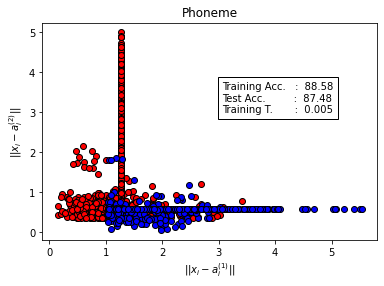

In [7]:
plt.scatter(XD[y_train==y_unique[0]][:, -2], XD[y_train==y_unique[0]][:, -1], c='red', edgecolors='k')
plt.scatter(XD[y_train == y_unique[1]][:, -2], XD[y_train == y_unique[1]][:, -1], c='blue', edgecolors='k')
plt.xlabel(r'$||x_i-a_i^{(1)}||$')
plt.ylabel(r'$||x_i-a_i^{(2)}||$')
plt.text(XD[:,-2].max() - 0.5,XD[:,-1].max() - 2, \
         "Training Acc.   :  %.2f\nTest Acc.         :  %.2f\nTraining T.       :  %.3f" % \
         (score_training,score_test,train_time), size=10,\
         va="baseline", ha="right", multialignment="left", \
         bbox=dict(fc="none"))

plt.title('Phoneme')

plt.show()